<a href="https://colab.research.google.com/github/Radha-Lahoti/MAE271D-Seminar/blob/main/HW1_p1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
## Homework adapted from CS 159 by Dr. Ugo Rosolia at Caltech

import pdb
import numpy as np
from cvxopt import spmatrix, matrix, solvers
from numpy import linalg as la
from scipy import linalg
from scipy import sparse
from cvxopt.solvers import qp
import datetime
from numpy import hstack, inf, ones
from scipy.sparse import vstack
from osqp import OSQP
from dataclasses import dataclass, field
import matplotlib.pyplot as plt
from matplotlib import rc


In [79]:
class FTOCP(object):
	""" Finite Time Optimal Control Problem (FTOCP)
	Methods:
		- solve: solves the FTOCP given the initial condition x0 and terminal contraints
		- buildNonlinearProgram: builds the ftocp program solved by the above solve method
		- model: given x_t and u_t computes x_{t+1} = f( x_t, u_t )

	"""

	def __init__(self, N, A, B, Q, R, Qf, Fx, bx, Fu, bu, Ff, bf, printLevel):
		# Define variables
		self.printLevel = printLevel

		self.A  = A
		self.B  = B
		self.N  = N
		self.n  = A.shape[1]
		self.d  = B.shape[1]
		self.Fx = Fx
		self.bx = bx
		self.Fu = Fu
		self.bu = bu
		self.Ff = Ff
		self.bf = bf
		self.Q  = Q
		self.Qf = Qf
		self.R  = R

		print("Initializing FTOCP")
		self.buildCost()
		self.buildIneqConstr()
		self.buildEqConstr()
		print("Done initializing FTOCP")

		self.time = 0


	def solve(self, x0):
		"""Computes control action
		Arguments:
		    x0: current state
		"""

		# Solve QP
		startTimer = datetime.datetime.now()
		self.osqp_solve_qp(self.H, self.q, self.G_in, np.add(self.w_in, np.dot(self.E_in,x0)), self.G_eq, np.dot(self.E_eq,x0) )
		endTimer = datetime.datetime.now(); deltaTimer = endTimer - startTimer
		self.solverTime = deltaTimer

		# Unpack Solution
		self.unpackSolution(x0)

		self.time += 1

		return self.uPred[0,:]

	def unpackSolution(self, x0):
		# Extract predicted state and predicted input trajectories
		self.xPred = np.vstack((x0, np.reshape((self.Solution[np.arange(self.n*(self.N))]),(self.N,self.n))))
		self.uPred = np.reshape((self.Solution[self.n*(self.N)+np.arange(self.d*self.N)]),(self.N, self.d))

		if self.printLevel >= 2:
			print("Optimal State Trajectory: ")
			print(self.xPred)

			print("Optimal Input Trajectory: ")
			print(self.uPred)

		if self.printLevel >= 1: print("Solver Time: ", self.solverTime.total_seconds(), " seconds.")

	def buildIneqConstr(self):
		# Hint 1: consider building submatrices and then stack them together
		# Hint 2: most likely you will need to use auxiliary variables
		Ix = np.eye(self.n)
		Iu = np.eye(self.d)
		Gx_in = linalg.block_diag(*([self.Fx] * self.N))

    # For inputs (2*N blocks, because of +/-)
		Gu_in = linalg.block_diag(*([self.Fu] * self.N))

    # Combine
		top = np.hstack([Gx_in, np.zeros((2*self.N*self.n, self.N*self.d))])

		bottom = np.hstack([np.zeros((2*self.N*self.d, self.N*self.n)), Gu_in])

		G_in = np.vstack([top, bottom])
		# debug
		print(np.shape(G_in))

		E_in = np.zeros((2*self.N*self.n + 2*self.N*self.d, self.n))

		w_in = np.vstack([
				np.tile(self.bx.reshape(-1,1), (self.N,1)),
				np.tile(self.bu.reshape(-1,1), (self.N,1))
		]).flatten()

		if self.printLevel >= 2:
			print("G_in: ")
			print(G_in)
			print("E_in: ")
			print(E_in)
			print("w_in: ", w_in)

		self.G_in = sparse.csc_matrix(G_in)
		self.E_in = E_in
		self.w_in = w_in.T

	def buildCost(self):
		# Hint: you could use the function "linalg.block_diag"
		barQ = linalg.block_diag(*([self.Q] * self.N))
		barR = linalg.block_diag(*([self.R] * self.N))

		H = linalg.block_diag(barQ, barR)
		q = np.zeros(H.shape[0])

		if self.printLevel >= 2:
			print("H: ")
			print(H)
			print("q: ", q)

		self.q = q
		self.H = sparse.csc_matrix(2 * H)  #  Need to multiply by two because CVX considers 1/2 in front of quadratic cost

	def buildEqConstr(self):
		# Hint 1: consider building submatrices and then stack them together
		# Hint 2: most likely you will need to use auxiliary variables
		n_x = self.n  # state dimension
		n_u = self.d  # input dimension

		# --- Build G0_eq and E0_eq ---
		# G0_eq will have (N * n_x) rows and (N * (n_x + n_u)) columns
		Gx_blocks = []
		Gu_blocks = []

		for i in range(self.N):
				Gx_row = [-self.A if j == i-1 else (np.eye(n_x) if j == i else np.zeros((n_x, n_x)))
									for j in range(self.N)]
				Gx_blocks.append(np.hstack(Gx_row))

				Gu_row = [(-self.B if j == i else np.zeros((n_x, n_u))) for j in range(self.N)]
				Gu_blocks.append(np.hstack(Gu_row))

		G_eq = np.hstack([np.vstack(Gx_blocks), np.vstack(Gu_blocks)])
		E_eq = np.vstack([self.A] + [np.zeros((n_x, n_x)) for _ in range(self.N-1)])

		if self.printLevel >= 2:
			print("G_eq: ")
			print(G_eq)
			print("E_eq: ")
			print(E_eq)

		self.G_eq = sparse.csc_matrix(G_eq)
		self.E_eq = E_eq

	def osqp_solve_qp(self, P, q, G= None, h=None, A=None, b=None, initvals=None):
		"""
		self.osqp_solve_qp(self.H, self.q, self.G_in, np.add(self.w_in, np.dot(self.E_in,x0)), self.G_eq, np.dot(self.E_eq,x0) )
		Solve a Quadratic Program defined as:
		minimize
			(1/2) * x.T * P * x + q.T * x
		subject to
			G * x <= h
			A * x == b
		using OSQP <https://github.com/oxfordcontrol/osqp>.
		"""

		qp_A = vstack([G, A]).tocsc()
		l = -inf * np.ones(len(h))

		# # Make sure all vectors are 1D arrays before stacking
		# if len(l.shape) != 1:
		# 		l = l.flatten()
		# if b is not None and len(b.shape) != 1:
		# 		b = b.flatten()
		# if len(h.shape) != 1:
		# 		h = h.flatten()

		qp_l = hstack([l, b])
		qp_u = hstack([h, b])

		self.osqp = OSQP()
		self.osqp.setup(P=P, q=q, A=qp_A, l=qp_l, u=qp_u, verbose=False, polish=True)

		if initvals is not None:
			self.osqp.warm_start(x=initvals)
		res = self.osqp.solve()
		if res.info.status_val == 1:
			self.feasible = 1
		else:
			self.feasible = 0
			print("The FTOCP is not feasible at time t = ", self.time)

		self.Solution = res.x


Initializing FTOCP
H: 
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 10.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 10.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 10.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 10.]]
q:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(24, 12)
G_in: 
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]


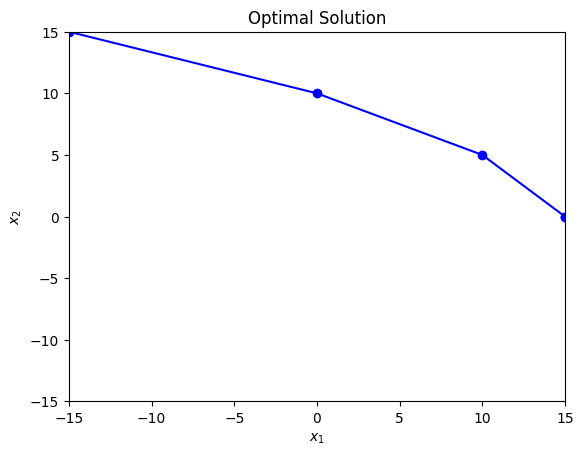

In [80]:
# Initialize system parameters
A = np.array([[1, 1],
	          [0, 1]]);
B = np.array([[0],
			  [1]]);

x0    = np.array([-15.0,15.0])   # initial condition

# Initialize ftocp parameters
printLevel = 3
N  = 4; n = 2; d = 1;
Q      = np.eye(n)
R      = 10*np.eye(d)
Qf     = np.eye(n)

# State constraint set X = \{ x : F_x x \leq b_x \}
Fx = np.vstack((np.eye(n), -np.eye(n)))
bx = np.array([15,15]*(2))

# Input constraint set U = \{ u : F_u u \leq b_u \}
Fu = np.vstack((np.eye(d), -np.eye(d)))
bu = np.array([5]*2)

Ff = Fx
bf = bx

# =====================================================
# Solve FTOCP and plot the solutiob
ftocp = FTOCP(N, A, B, Q, R, Qf, Fx, bx, Fu, bu, Ff, bf, printLevel)

ftocp.solve(x0)

plt.figure()
plt.plot(ftocp.xPred[:,0], ftocp.xPred[:,1], '-ob')
plt.title('Optimal Solution')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.show()